# SVM Models

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

### Obtención de los datos

In [6]:
# 1. Cargar los datos
df = pd.read_csv('../../train.csv')

# 2. Crear la variable de respuesta categórica basada en los terciles del precio de venta
tercil_1 = df['SalePrice'].quantile(1/3)
tercil_2 = df['SalePrice'].quantile(2/3)

# Crear la categoría de precio
df['PriceCategory'] = pd.cut(
    df['SalePrice'], 
    bins=[0, tercil_1, tercil_2, float('inf')], 
    labels=['Económica', 'Intermedia', 'Cara']
)

# 3. Seleccionar las características para el modelo
selected_features = [
    'OverallQual',    # Calidad general
    'GrLivArea',      # Área habitable
    'GarageCars',     # Capacidad del garaje
    'YearBuilt',      # Año de construcción
    'TotalBsmtSF',    # Superficie total del sótano
    'FullBath',       # Baños completos
    'Neighborhood',   # Vecindario (categórica)
    'ExterQual',      # Calidad del exterior (categórica)
    'KitchenQual',    # Calidad de la cocina (categórica)
    'BsmtQual'        # Calidad del sótano (categórica)
]

# 4. Preparar los datos
X = df[selected_features].copy()
y = df['PriceCategory']

## Exploración

In [7]:
X.describe()

,OverallQual,GrLivArea,GarageCars,YearBuilt,TotalBsmtSF,FullBath
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,1515.463699,1.767123,1971.267808,1057.429452,1.565068
std,1.382997,525.480383,0.747315,30.202904,438.705324,0.550916
min,1.000000,334.000000,0.000000,1872.000000,0.000000,0.000000
25%,5.000000,1129.500000,1.000000,1954.000000,795.750000,1.000000
50%,6.000000,1464.000000,2.000000,1973.000000,991.500000,2.000000
75%,7.000000,1776.750000,2.000000,2000.000000,1298.250000,2.000000
max,10.000000,5642.000000,4.000000,2010.000000,6110.000000,3.000000


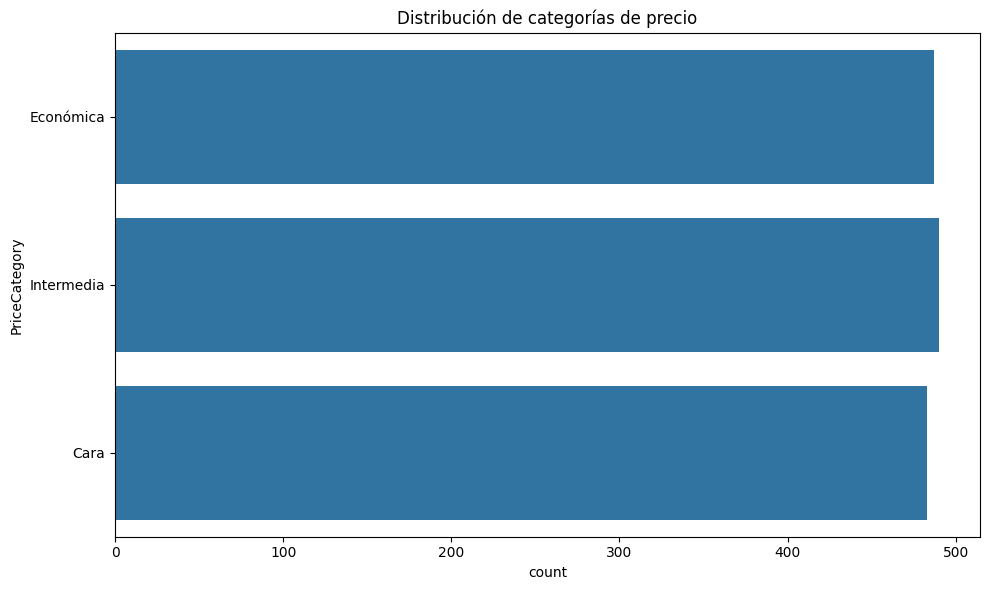

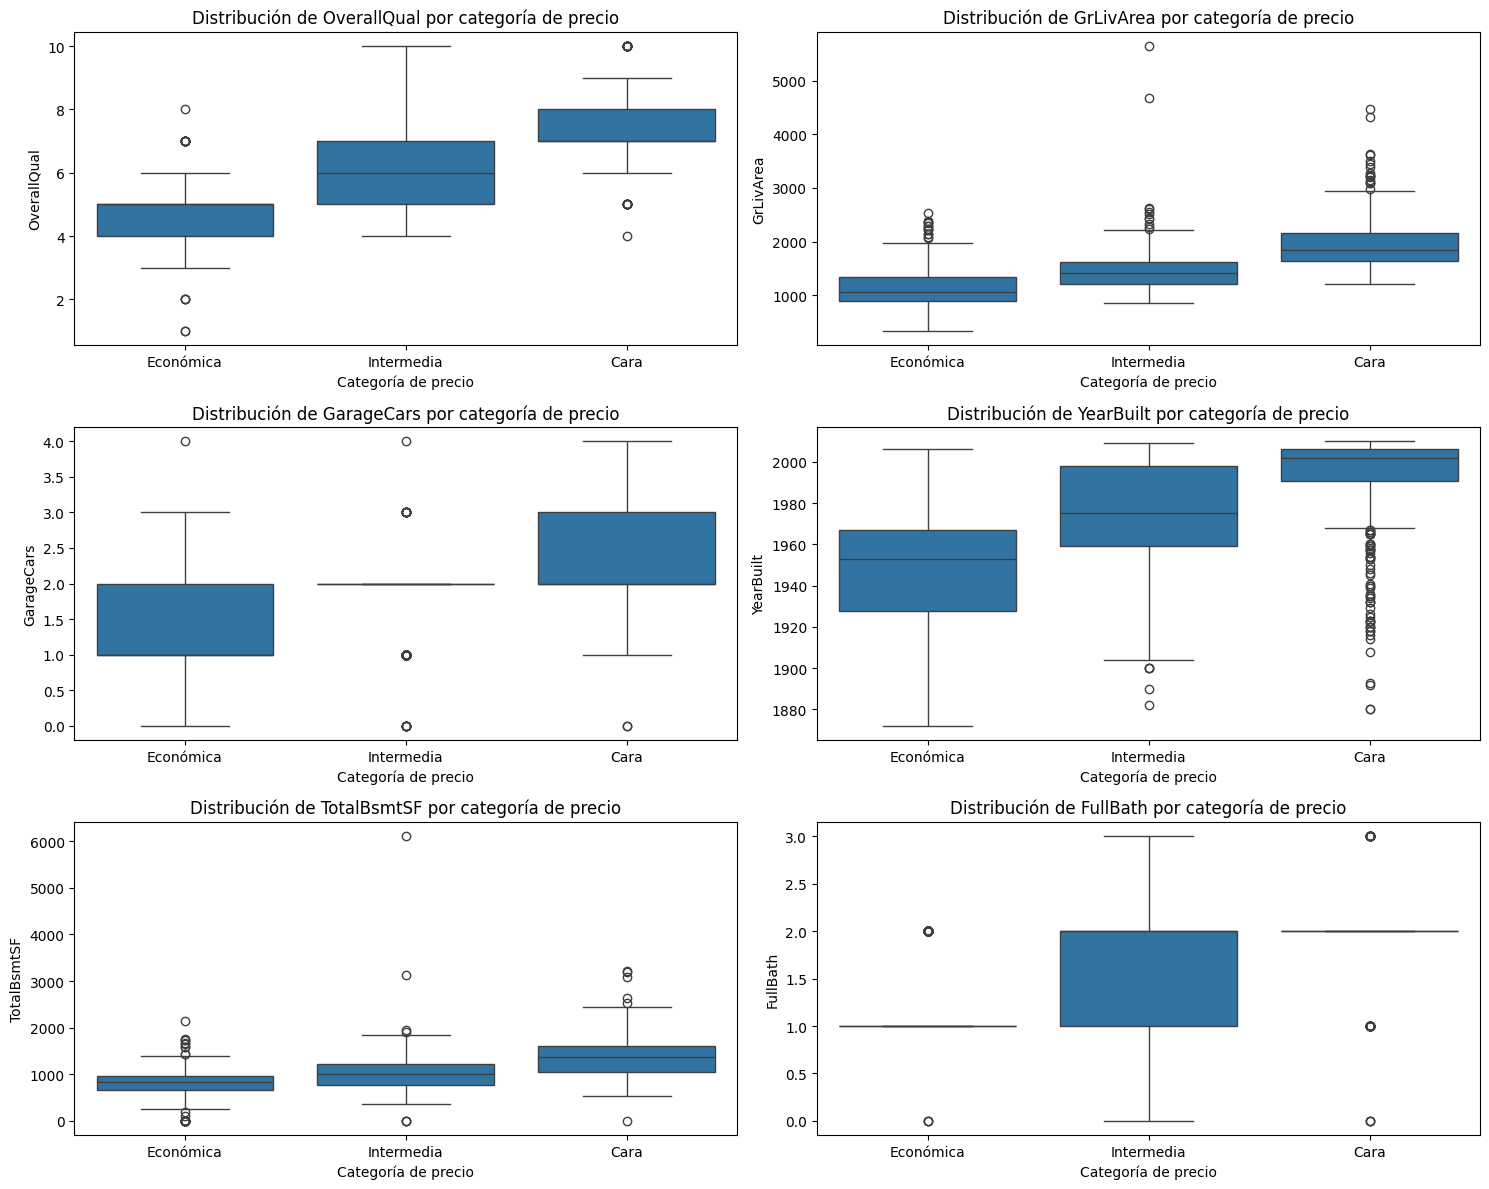

In [13]:
# 1. Distribución de la variable objetivo
plt.figure(figsize=(10, 6))
sns.countplot(y=y)
plt.title('Distribución de categorías de precio')
plt.tight_layout()
plt.show()

# 2. Distribución de las variables numéricas por categoría de precio
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

numeric_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt', 'TotalBsmtSF', 'FullBath']

for i, col in enumerate(numeric_cols):
    if i < len(axes):
        sns.boxplot(x=df['PriceCategory'], y=df[col], ax=axes[i])
        axes[i].set_title(f'Distribución de {col} por categoría de precio')
        axes[i].set_xlabel('Categoría de precio')
        axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

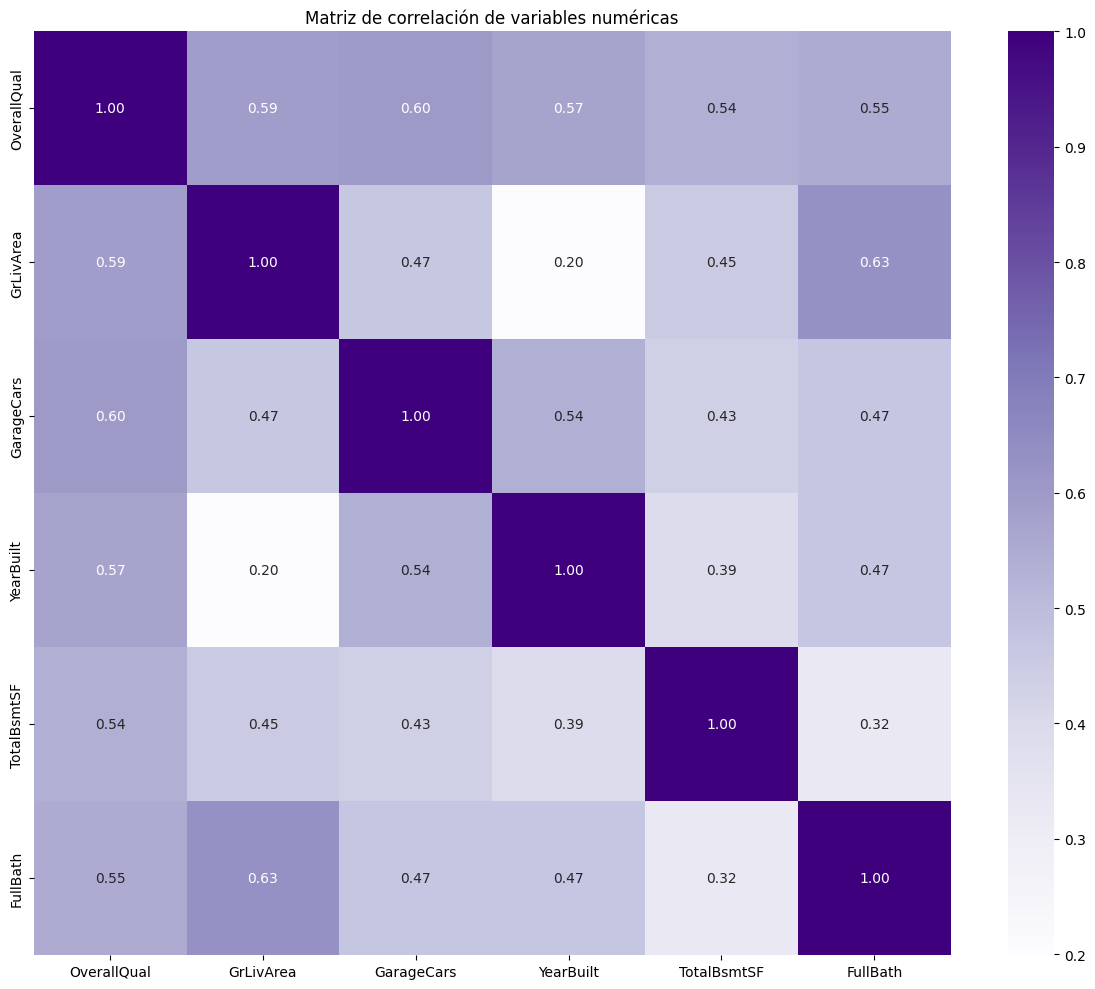

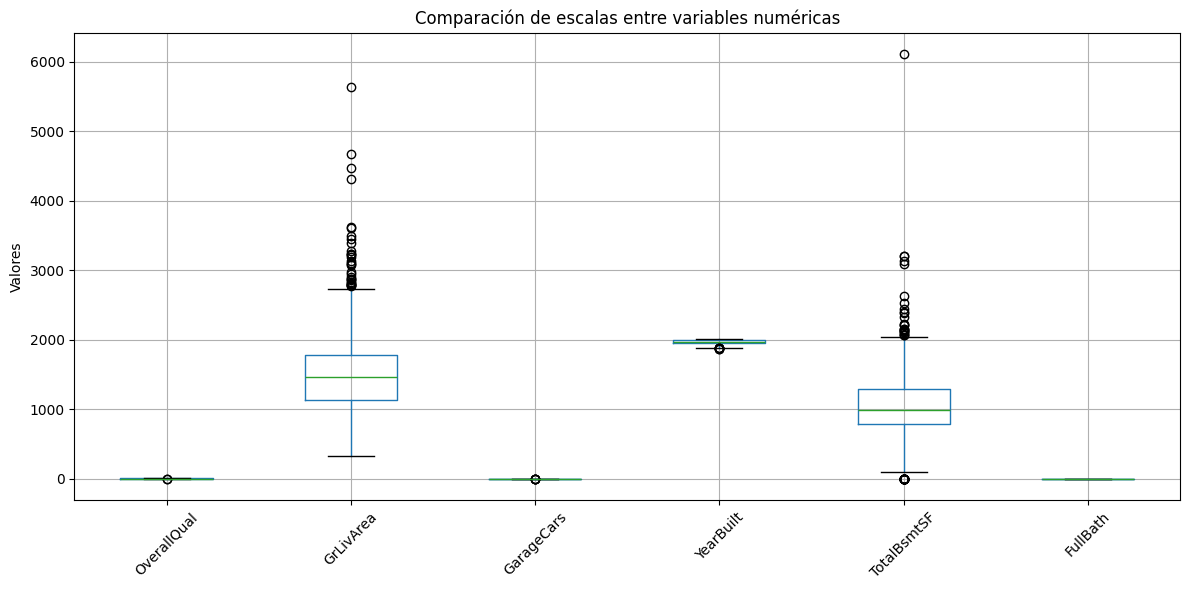

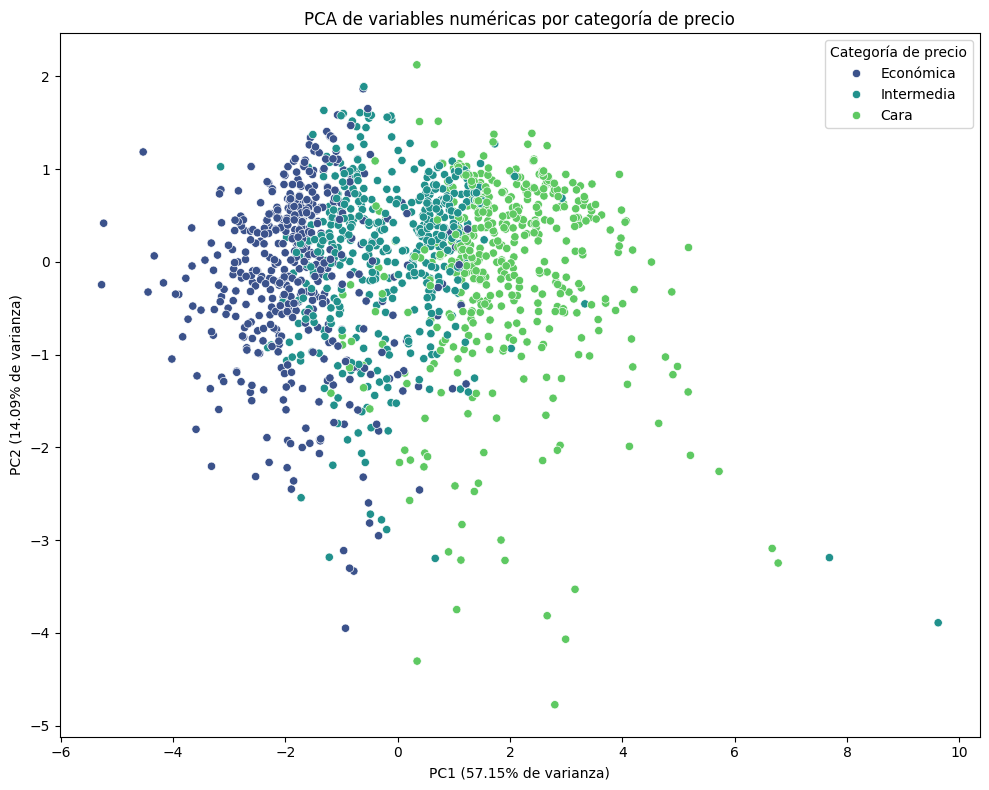

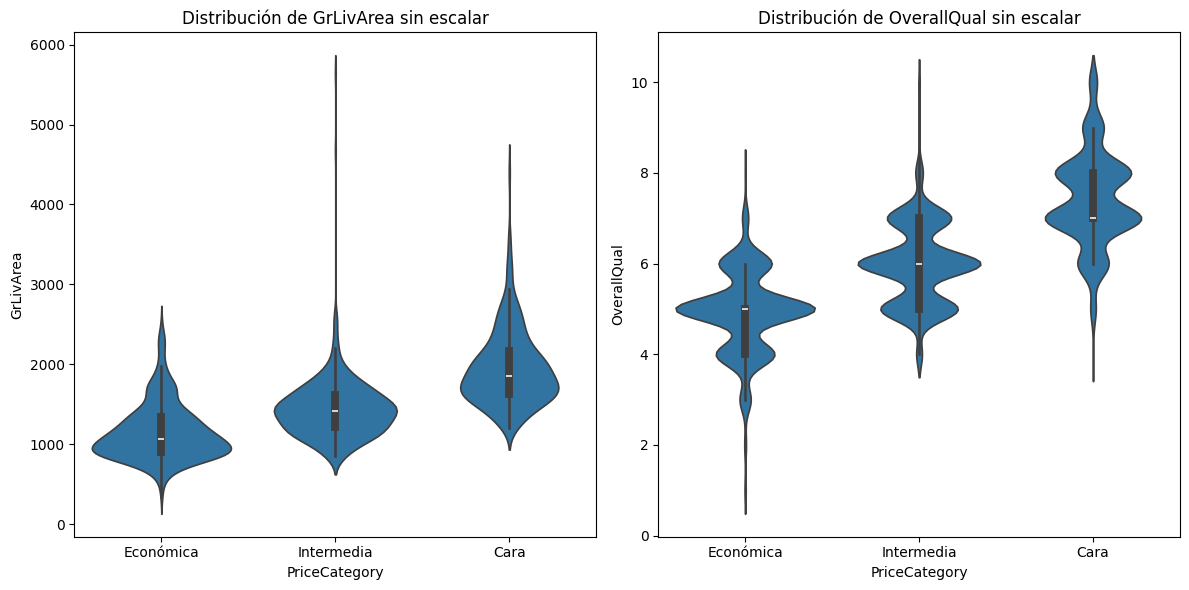

In [42]:
from sklearn.decomposition import PCA

# 3. Matriz de correlación de variables numéricas
plt.figure(figsize=(12, 10))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Purples', fmt='.2f')
plt.title('Matriz de correlación de variables numéricas')
plt.tight_layout()
plt.show()

# 4. Análisis de la escala de las variables numéricas
plt.figure(figsize=(12, 6))
df[numeric_cols].boxplot()
plt.title('Comparación de escalas entre variables numéricas')
plt.ylabel('Valores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Visualización de PCA en 2D coloreado por categoría de precio
# Primero escalar los datos numéricos
from sklearn.preprocessing import StandardScaler
X_numeric = X[numeric_cols].copy()
X_numeric_scaled = StandardScaler().fit_transform(X_numeric)

# Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_numeric_scaled)

# Crear un DataFrame para facilitar la visualización
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['PriceCategory'] = y.values

# Visualizar
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='PriceCategory', data=pca_df, palette='viridis')
plt.title('PCA de variables numéricas por categoría de precio')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} de varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} de varianza)')
plt.legend(title='Categoría de precio')
plt.tight_layout()
plt.show()

# 7. Gráfico de violín para mostrar la necesidad de escalado
plt.figure(figsize=(12, 6))
# Seleccionar dos variables con escalas muy diferentes
var1 = 'GrLivArea'  # Área habitable (valores grandes)
var2 = 'OverallQual'  # Calidad (valores pequeños)
  
plt.subplot(1, 2, 1)
sns.violinplot(x='PriceCategory', y=var1, data=df)
plt.title(f'Distribución de {var1} sin escalar')
  
plt.subplot(1, 2, 2)
sns.violinplot(x='PriceCategory', y=var2, data=df)
plt.title(f'Distribución de {var2} sin escalar')
  
plt.tight_layout()
plt.show()

## Transformaciones

In [26]:
# Manejar valores faltantes en características numéricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='median')
X[numeric_features] = imputer.fit_transform(X[numeric_features])

# Manejar valores faltantes en características categóricas
categorical_features = X.select_dtypes(include=['object']).columns
X[categorical_features] = X[categorical_features].fillna('None')

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [27]:
numeric_preprocessor = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Se preparan los preprocesadores
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

# Se transforman las colunas usando los preprocesadores
from sklearn.compose import ColumnTransformer

preprocesador = ColumnTransformer([
    ('one_hot_encoder',categorical_preprocessor,categorical_features),
    ('numerico', numeric_preprocessor,numeric_features)
],remainder="passthrough")

## Modelos SVM clasificación

In [36]:
# kernel lineal, C por defecto
modelo_svc_lineal = make_pipeline(preprocesador, SVC(kernel="linear"))

# Esto nos permite ver dentro del modelo
from sklearn import set_config
set_config(display='diagram')
modelo_svc_lineal

modelo_svc_lineal.fit(X_train, y_train)
param_grid = {
    'svc__C': (0.01, 0.1, 1, 5,16,32)
    }
modelGS_svc_lineal = GridSearchCV(modelo_svc_lineal, param_grid=param_grid,
                                 n_jobs=2, cv=10)
modelGS_svc_lineal.fit(X_train, y_train)
accuracy = modelGS_svc_lineal.score(X_test,y_test)
print("Accuracy: ",accuracy)
modelGS_svc_lineal.best_params_

Accuracy:  0.8036529680365296


{'svc__C': 16}

In [37]:
# kernel polinomial
modelo_svc_poly = make_pipeline(preprocesador, SVC(kernel="poly"))

modelo_svc_poly.fit(X_train, y_train)
param_grid = {
    'svc__C': (0.01, 0.1, 1, 5,16,32),
    'svc__degree':(2,3,5,7)
    }
modelGS_svc_poly = GridSearchCV(modelo_svc_poly, param_grid=param_grid,
                                 n_jobs=2, cv=10)
modelGS_svc_poly.fit(X_train, y_train)
accuracy = modelGS_svc_poly.score(X_test,y_test)
print("Accuracy: ",accuracy)
modelGS_svc_poly.best_params_

Accuracy:  0.7968036529680366


{'svc__C': 16, 'svc__degree': 2}

In [38]:
# kernel gaussiano
modelo_svc_rbf = make_pipeline(preprocesador, SVC(kernel="rbf"))

modelo_svc_rbf.fit(X_train, y_train)
param_grid = {
    'svc__C': (0.01, 0.1, 1, 5,16,32),
    'svc__gamma':(0.0000000002,0.00002,0.01,0.1,20,200 )
    }
modelGS_svc_rbf = GridSearchCV(modelo_svc_rbf, param_grid=param_grid,
                                 n_jobs=2, cv=10)
modelGS_svc_rbf.fit(X_train, y_train)
accuracy = modelGS_svc_rbf.score(X_test, y_test)
print("Accuracy: ",accuracy)
modelGS_svc_rbf.best_params_

Accuracy:  0.7922374429223744


{'svc__C': 5, 'svc__gamma': 0.01}

#### Predicción

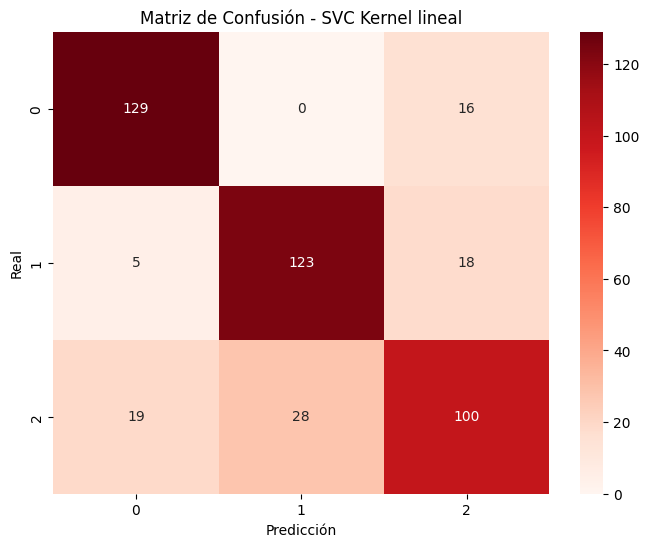

In [39]:
y_pred_lineal = modelGS_svc_lineal.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lineal)
# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - SVC Kernel lineal")
plt.show()

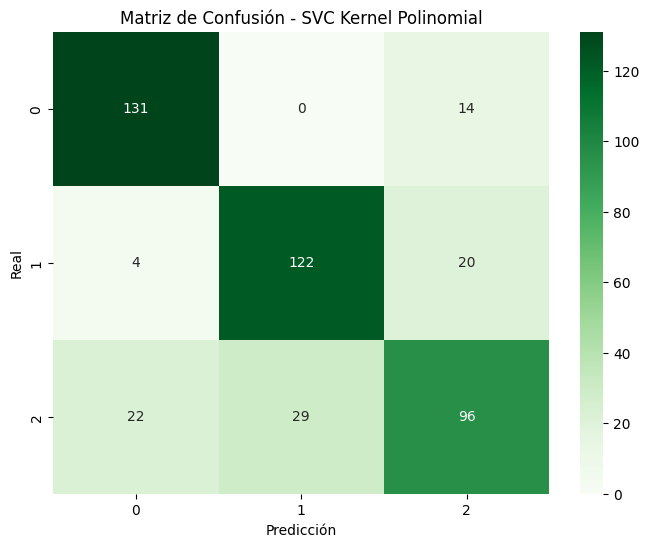

In [40]:
y_pred_poly = modelGS_svc_poly.predict(X_test)
cm = confusion_matrix(y_test, y_pred_poly)
# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - SVC Kernel Polinomial")
plt.show()

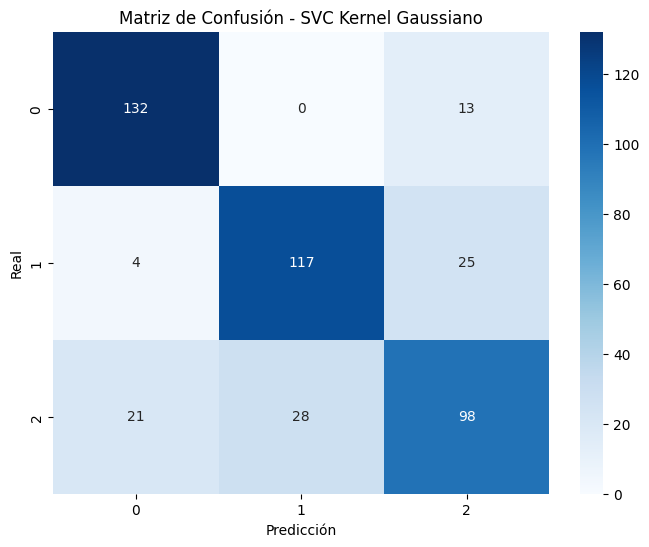

In [41]:
y_pred_rbf = modelGS_svc_rbf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rbf)
# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - SVC Kernel Gaussiano")
plt.show()